In [177]:
#라이브러리 불러오기
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def split_xy(dataset, time_steps, y_column): 
  #LSTM input data로 변환을 위한 (-1,time_stpes,time_steps) 형태로 데이터를 바꾸는 함수 (각 Time Step에 5개의 정보를 제공)
  x, y = list(), list()
  for i in range(len(dataset)):
    x_end_num = i + time_steps 
    y_end_num = x_end_num + y_column #time_steps + i + y_column = n번째 행 y 값

    if y_end_num > len(dataset):
      break
    tmp_x = dataset.iloc[i : x_end_num, :] #x값 (5x5)
    tmp_y = dataset.iloc[x_end_num : y_end_num, 3] #y값(종가 테이블 3번)
    x.append(np.array(tmp_x))
    y.append(np.array(tmp_y))

  return np.array(x), np.array(y)
#####################################################################
scaler = MinMaxScaler() #Scaler 객체 생성
data = pd.read_csv("/content/drive/MyDrive/Kospidata/KOSPIDATA.csv")
##print(data.head())#Data Import 확인
##plt.plot(data.Close) # 그래프 확인
data.drop(columns = "Adj Close", inplace = True) ##Adj Close 수정종가는 필요없음
data.set_index("Date", inplace = True) ##날짜 데이터 인덱스로 변환
##print(data.head())
##print(data.shape) #data shape 확인 (6381, 6) 
##print(data.shape)
x1, y1 = split_xy(data, 5, 1) ##time steps = 5
##print(x1.shape) #Shape 확인
##print(y1.shape)
x_train, x_test, y_train, y_test = train_test_split(x1,y1,test_size = 0.2, shuffle = False) ##전체 데이터 셋을 학습 0.8 테스트 0.2로 분할
##print(x_train.shape)
##print(x_test.shape) #결과 확인
###################Data 전처리 단계#############################################
#평균0 분산1 형태로 Scailing 하기 위해 데이터 Reshape
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
x_train = scaler.fit_transform(x_train)
x_test  = scaler.fit_transform(x_test) ##스케일링 진행
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

x_train = x_train.reshape(-1,5,5) #(-1,5,5) 형태로 Reshape
x_test = x_test.reshape(-1,5,5)
##############################LSTM 모델 훈련단계################################
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Dropout, GRU
from tensorflow.keras.losses import Huber
from tensorflow import keras
from keras.callbacks import EarlyStopping

#Model 1
input1 = Input(shape=(5,5), batch_size = 1)
GRU = GRU(64, input_shape=(5,5),batch_size = 1,stateful = True, activation ='tanh')(input1)
dense1 = Dense(32)(GRU)
output1 = Dense(1)(dense1)
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model = Model(inputs = input1, outputs = output1)
##print(model.summary())
early_stopping = EarlyStopping(patience = 5)
model.compile(loss = 'mse', optimizer = adam, metrics = 'mae')
model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(1, 5, 5)]               0         
                                                                 
 gru_7 (GRU)                 (1, 64)                   13632     
                                                                 
 dense_32 (Dense)            (1, 32)                   2080      
                                                                 
 dense_33 (Dense)            (1, 1)                    33        
                                                                 
Total params: 15,745
Trainable params: 15,745
Non-trainable params: 0
_________________________________________________________________


In [178]:
history = model.fit(x_train,y_train, shuffle = False, callbacks = [early_stopping], batch_size = 1, validation_split = 0.2, epochs = 50)

Epoch 1/50
3984/3984 [==============================] - 17s 4ms/step - loss: 4.7414e-04 - mae: 0.0141 - val_loss: 1.9367e-04 - val_mae: 0.0116
Epoch 2/50
3984/3984 [==============================] - 13s 3ms/step - loss: 2.3037e-04 - mae: 0.0110 - val_loss: 1.7588e-04 - val_mae: 0.0111
Epoch 3/50
3984/3984 [==============================] - 15s 4ms/step - loss: 2.1396e-04 - mae: 0.0104 - val_loss: 1.7774e-04 - val_mae: 0.0112
Epoch 4/50
3984/3984 [==============================] - 14s 4ms/step - loss: 2.0179e-04 - mae: 0.0100 - val_loss: 1.8231e-04 - val_mae: 0.0113
Epoch 5/50
3984/3984 [==============================] - 14s 4ms/step - loss: 1.9055e-04 - mae: 0.0097 - val_loss: 1.8626e-04 - val_mae: 0.0115
Epoch 6/50
3984/3984 [==============================] - 14s 4ms/step - loss: 1.8060e-04 - mae: 0.0094 - val_loss: 1.9133e-04 - val_mae: 0.0117
Epoch 7/50
3984/3984 [==============================] - 14s 4ms/step - loss: 1.7184e-04 - mae: 0.0091 - val_loss: 1.9285e-04 - val_mae: 0.0118

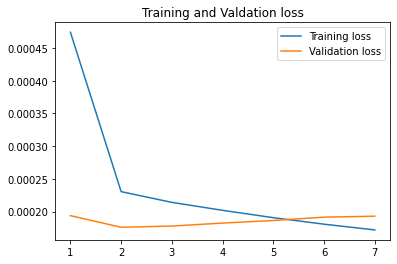

In [179]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Valdation loss')
plt.legend()
plt.show()  

In [180]:
y_pred = model.predict(x_test, batch_size = 1)
y_pred.shape

(1246, 1)

In [181]:
mse, mae = model.evaluate(x_test,y_test, batch_size = 1)

1246/1246 [==============================] - 2s 2ms/step - loss: 0.0056 - mae: 0.0662


In [182]:
real = np.concatenate((y_train,y_test))
forecast = np.concatenate((y_train,y_pred))

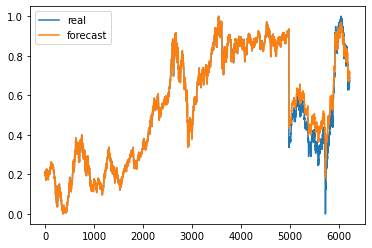

In [183]:
plt.plot(real, label = 'real')
plt.plot(forecast, label = 'forecast')
plt.legend()

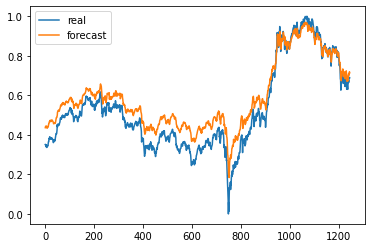

In [184]:
plt.plot(y_test, label = 'real')
plt.plot(y_pred, label = 'forecast')
plt.legend()

In [185]:
## 최근 데이터 테스트를 위한 전처리
data_t = pd.read_csv("/content/drive/MyDrive/Kospidata/KOSPITEST.csv")
data_t.drop(columns = 'Adj Close', inplace = True)
data_t.set_index('Date', inplace = True)
x_test2, y_test2 = split_xy(data_t, 5, 1)
x_test2 = x_test2.reshape(x_test2.shape[0], x_test2.shape[1]*x_test2.shape[2])
x_test2 = scaler.fit_transform(x_test2)
x_test2 = x_test2.reshape(-1,5,5)
y_test2 = scaler.fit_transform(y_test2)



In [186]:
y_pred2 = model.predict(x_test2, batch_size = 1)
y_pred2.shape


(241, 1)

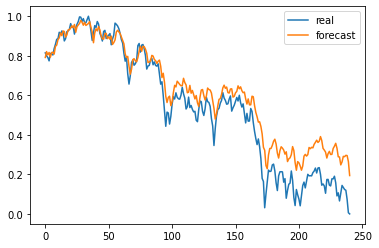

In [187]:
plt.plot(y_test2, label = 'real')
plt.plot(y_pred2, label = 'forecast')
plt.legend()